In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab.patches import cv2_imshow
import math
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GREEN = (0 , 255, 0) 
BLUE = (255, 0, 0)
RED = (0, 0, 255)
YELLOW = (0, 255, 255)
PINK = (255, 0, 255)
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# 定義角度to時間
def angle_to_hour(angle):
    hour = math.floor(angle / 30)
    return hour

def angle_to_min(angle):
    min = math.floor(angle / 6)
    return min

def distance_point_to_line(point, line_start, line_end):
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    # 计算点到直线的距离
    distance = np.linalg.norm(np.cross(line_end - line_start, line_start - point))/np.linalg.norm(line_end - line_start)
    return distance

def distance_point_to_point(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    distance = np.linalg.norm(point1 - point2)
    return distance

# 提取中心線 (尖形指針)
def detect_center_line(image):
    # preprocessing
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.blur(img_gray, (13, 13))
    # cv2_imshow(img_blur)
    _, thin = cv2.threshold(img_blur, 130, 255, 0)
    # cv2_imshow(thin)

    # 遮罩
    # cv2.circle(thin, (CenterX, CenterY), int(Radius*0.07), WHITE, -1)
    # cv2_imshow(thin)

    thin = 255 - thin 
    # find contours
    thin = cv2.ximgproc.thinning(thin, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    # cv2_imshow(thin)
    return thin

# find circle
def detect_circle(image):
    img_show = image.copy()
    # cv2_imshow(img_show)
    size = np.shape(image)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.GaussianBlur(img, (29, 29), 0)
    # cv2_imshow(img_blur)
    circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, int(max(size)), param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for cir in circles[0]:
            # print('circle.shape:',cir.shape,'circle:',cir)
            Center_X = int(cir[0])
            Center_Y = int(cir[1])
            Radius = int(cir[2])
            cv2.circle(img_show, (cir[0], cir[1]), cir[2], GREEN, 4)
            cv2.circle(img_show, (cir[0], cir[1]), 2, RED, 3)
            cv2.circle(img_show, (Center_X, Center_Y), 2, (255, 255, 0), -1)
            # cv2_imshow(img_show)
            # print("centerX, centerY:", Center_X, Center_Y)
            # print("Radius:", Radius)
        return (Center_X, Center_Y, Radius)

# 線段重疊像素點個數
def get_overlap_pixels(x1, y1, x2, y2, x3, y3, x4, y4):
    
    # 找出所有線段中 x 和 y 坐標的最小值和最大值
    min_x = min(x1, x2, x3, x4)
    max_x = max(x1, x2, x3, x4)
    min_y = min(y1, y2, y3, y4)
    max_y = max(y1, y2, y3, y4)
    # 計算畫布大小
    canvas_size = max(max_x - min_x, max_y - min_y) + 1
    # 設定畫布
    canvas1 = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
    canvas2 = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
    # 轉換坐標系，將線段坐標轉換為相對於畫布左上角的坐標
    x1, y1 = x1 - min_x, y1 - min_y
    x2, y2 = x2 - min_x, y2 - min_y
    x3, y3 = x3 - min_x, y3 - min_y
    x4, y4 = x4 - min_x, y4 - min_y
    # 畫出兩條線段
    cv2.line(canvas1, (x1, y1), (x2, y2), 255, thickness=2)
    cv2.line(canvas2, (x3, y3), (x4, y4), 255, thickness=2)
    # cv2_imshow(canvas1)
    # cv2_imshow(canvas2)
    # 計算兩條線段的交集
    intersection = cv2.bitwise_and(canvas1, canvas2)
    # cv2_imshow(intersection)
    # 計算交集像素點數量
    overlap_pixels = np.sum(intersection == 255)
    return overlap_pixels

def getHandPos(Cx, Cy, x1, y1, x2, y2):
    if (distance_point_to_point((Cx, Cy), (x1, y1)) >= distance_point_to_point((Cx, Cy), (x2, y2))):
        # return distance_point_to_point((Cx, Cy), (x1, y1)), x1, y1
        return x1, y1
    else:
        # return distance_point_to_point((Cx, Cy), (x2, y2)), x2, y2
        return x2, y2

# 點斜式
def get_Line_Circle_Intersection(center, radius, slope):
    # 計算線段的截距
    intercept = center[1] - slope * center[0]

    # 計算線段和圓的交點
    a = 1.0 + slope**2
    b = -2 * center[0] + 2 * slope * (intercept - center[1])
    c = center[0]**2 + (intercept - center[1])**2 - radius**2

    delta = b**2 - 4 * a * c
    if delta >= 0:
        x1 = (-b + np.sqrt(delta)) / (2 * a)
        y1 = slope * x1 + intercept
        x2 = (-b - np.sqrt(delta)) / (2 * a)
        y2 = slope * x2 + intercept
        return ((x1, y1),  (x2, y2))
    else:
        x1 = x2 = y1 = y2 = None
        return None

def judge(a, b, p):
    a = np.array(a)
    b = np.array(b)
    p = np.array(p)
    if (np.cross(p-a, b-a) > 0):
        return True
    elif np.cross(p-a, b-a) < 0:
        return False
    else:
        return None

# 頂點 終點 起點
def get_angle(p1, p2, p3):

    length_p1p2 = math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)
    length_p1p3 = math.sqrt((p3[0] - p1[0]) ** 2 + (p3[1] - p1[1]) ** 2)

    vector_p1p2 = ((p2[0] - p1[0]) / length_p1p2, (p2[1] - p1[1]) / length_p1p2)
    vector_p1p3 = ((p3[0] - p1[0]) / length_p1p3, (p3[1] - p1[1]) / length_p1p3)

    angle = math.atan2(vector_p1p3[1], vector_p1p3[0]) - math.atan2(vector_p1p2[1], vector_p1p2[0])
    angle = math.degrees(angle)

    angle = angle % 360

    return angle


# 判斷方向
def get_slope(x1, y1, x2, y2):
    if x2 == x1:
        return None
    elif y2 == y1:
        return 0
    else:
        return (y2 - y1) / (x2 - x1)


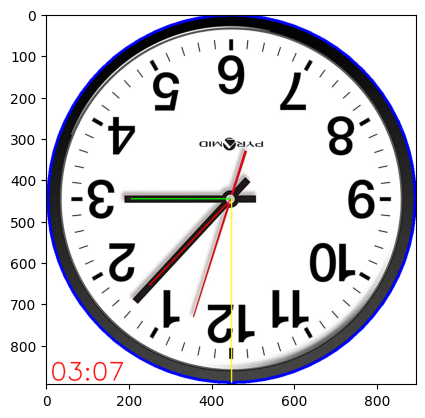

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/analog clock recognize/img/clock_rotate5.jpg'

img = cv2.imread(path)
img_copy = img.copy() # 用來畫圖顯示標記

# cv2_imshow(img)

# (x, y, R)
circle = detect_circle(img)
center_x = circle[0]
center_y = circle[1]
radius = circle[2]

# 判斷ㄉ矩形
r = int(radius*0.25)
polygon = np.array([[center_x - r, center_y], [center_x, center_y + r], [center_x + r, center_y], [center_x, center_y - r]], np.int32) 
# cv2.polylines(img_copy, [polygon], True, BLUE, 1)


# Center Line Detect
line = detect_center_line(img)
# cv2_imshow(line)
lines = cv2.HoughLinesP(line, 1, math.pi/180.0, 20, minLineLength=10, maxLineGap=5)
if lines is not None:
    hand_arr = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # cv2.line(img_copy, (x1, y1), (x2, y2), GREEN, 2)
        
        # 過濾雜線(是否在矩形內)
        if ((cv2.pointPolygonTest(polygon, (int(x1), int(y1)), False) >= 0) or (cv2.pointPolygonTest(polygon, (int(x2), int(y2)), False) >= 0)):
            temp = [x1, y1, x2, y2]
            hand_arr.append(temp)
            # print(x1, y1, x2, y2)
            # cv2.line(img_copy, (x1, y1), (x2, y2), RED, 2)
            # cv2_imshow(img_copy)
    
    # 刪除重複線
    for i in range(len(hand_arr)):
        for j in range(i+1, len(hand_arr)):
            # print(get_overlap_pixels(hand_arr[i][0], hand_arr[i][1], hand_arr[i][2], hand_arr[i][3],
            #                        hand_arr[j][0], hand_arr[j][1], hand_arr[j][2], hand_arr[j][3]))
            if (get_overlap_pixels(hand_arr[i][0], hand_arr[i][1], hand_arr[i][2], hand_arr[i][3],
                                   hand_arr[j][0], hand_arr[j][1], hand_arr[j][2], hand_arr[j][3]) >= 50 ):
                if (distance_point_to_point((hand_arr[i][0], hand_arr[i][1]), (hand_arr[i][2], hand_arr[i][3])) >= 
                    distance_point_to_point((hand_arr[j][0], hand_arr[j][1]), (hand_arr[j][2], hand_arr[j][3]))):
                    del hand_arr[j]
                    break
                else:
                    del hand_arr[i]
                    break
    # cv2_imshow(img_copy)            
    # 判斷長短針
    hand_distance_arr = []
    for i in range(len(hand_arr)):
        temp = distance_point_to_point((hand_arr[i][0], hand_arr[i][1]), (hand_arr[i][2], hand_arr[i][3]))
        hand_distance_arr.append(temp)

        # cv2.line(img_copy, (hand_arr[i][0], hand_arr[i][1]), (hand_arr[i][2], hand_arr[i][3]), GREEN, 2)
    # cv2_imshow(img_copy)
    result_arr = np.insert(np.array(hand_arr, dtype=np.float32), 0, np.array(hand_distance_arr), axis=1)
    # print(len(result_arr))

    # 判斷是否指偵測到2條直線
    if (len(result_arr) >= 2):
        # 按照每行第一個元素排序 返回排序後的索引
        sort_indices = result_arr[:,0].argsort()[::-1]
        # 對陣列進行重新排序 保持列的順序不變
        result_arr = result_arr[sort_indices]
        # print(result_arr)
        
        # GREEN is long hand; RED is short hand
        # 計算圓心到指針的座標
        long_hand_pos = getHandPos(center_x, center_y, result_arr[0][1], result_arr[0][2], result_arr[0][3], result_arr[0][4])
        short_hand_pos = getHandPos(center_x, center_y, result_arr[1][1], result_arr[1][2], result_arr[1][3], result_arr[1][4])

        # print(long_hand_pos, short_hand_pos)

        cv2.line(img_copy, (center_x, center_y), (int(long_hand_pos[0]), int(long_hand_pos[1])), RED, 2)
        cv2.line(img_copy, (center_x, center_y), (int(short_hand_pos[0]), int(short_hand_pos[1])), GREEN, 2)

        # print(np.array(hand_arr))
        # print(np.array(hand_distance_arr))
        # print(result_arr)
    else:
        long_hand_pos = short_hand_pos = getHandPos(center_x, center_y, result_arr[0][1], result_arr[0][2], result_arr[0][3], result_arr[0][4])    
# print(long_hand_pos, short_hand_pos)
# cv2_imshow(img_copy)

# 判斷方向
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.blur(img, (5, 5)) # 模糊

_, img = cv2.threshold(img, 110, 255, 0) # 二值化

img = cv2.circle(img, (center_x, center_y), int(radius/2), WHITE, -1) # 指針覆蓋
img_copy1 = img.copy()

# cv2_imshow(img)

# 找出每個數字的輪廓
contours_list, hierarchy = cv2.findContours(img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE) 

areas = []
perimeters = []
contourses = []
for cnt in contours_list:
    if (cv2.contourArea(cnt) > 400 and cv2.contourArea(cnt) < r*r*np.pi/12): # 過濾輪廓 400 100
        x, y, w, h = cv2.boundingRect(cnt)
        roi = img[y:y+h, x:x+w]
        # cv2.rectangle(img_copy1 , (x, y), (x + w, y + h), GREEN, 2)
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        contourses.append(cnt)
        perimeters.append(perimeter)
        areas.append(area)
        # print(area)
        # cv2_imshow(roi)
# plt.imshow(cv2.cvtColor(img_copy1, cv2.COLOR_BGR2RGB))
threshold_p = 300 # 周長 50 300
threshold_a = 100 # 面積 100 100

# 將元素按照相似度分組
groups1 = defaultdict(list)
groups2 = defaultdict(list)

for i in range(len(contourses)):
    for j in range(i + 1, len(contourses)):
        if abs(perimeters[i] - perimeters[j]) <= threshold_p:
            groups1[i].append(j)
            groups1[j].append(i)

        if abs(areas[i] - areas[j]) <= threshold_a:
            groups2[i].append(j)
            groups2[j].append(i)
# print(groups1)
# print(groups2)
# 找到最大的相似度分組
max_group1 = max(groups1.values(), key=len)
max_group2 = max(groups2.values(), key=len)

# 取交集
both = list(set(max_group1).intersection(set(max_group2)))
# print(both)

for i in both:
    # 找交集中偵測到直線的圖片 找1的斜率
    x, y, w, h = cv2.boundingRect(contourses[i])
    # cv2.rectangle(img_copy1 , (x, y), (x + w, y + h), GREEN, 2)
    roi = img[y:y+h, x:x+w]
    roi_color = img_copy[y:y+h, x:x+w]

    # plt.subplot(1, 2, 1)
    # plt.title('origin')
    # plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
    # cv2_imshow(roi_color)

    edges = cv2.Canny(roi, 50, 150)
    # cv2_imshow(edges)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=(h if h<=w else w)-10, maxLineGap=10) 
    # print(lines)
    if lines is not None: 
        x1, y1, x2, y2 = lines[0][0]
        jx, jy = x+x1, y+y1 
        # cv2.line(roi_color, (x1, y1), (x2, y2), PINK, 3)

        # plt.subplot(1, 2, 2)
        # plt.title('slope = None')
        # plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
        # cv2_imshow(roi_color)
        # print(x1, y1, x2, y2)
        break
    else:
        jx = jy = None
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.circle(img_copy, (center_x, center_y), radius, BLUE, 5)

vertical_slope = get_slope(x1, y1, x2, y2)

if jx is not None:
    if vertical_slope is None:
        vertical_pt1, vertical_pt2 = (center_x, center_y + radius), (center_x, center_y - radius)
        horizontal_pt1, horizontal_pt2 = (center_x + radius, center_y), (center_x - radius, center_y)
        # print(vertical_slope)
    elif (vertical_slope == 0):
        vertical_pt1, vertical_pt2 = (center_x + radius, center_y), (center_x - radius, center_y)
        horizontal_pt1, horizontal_pt2 = (center_x, center_y + radius), (center_x, center_y - radius)
        # print(vertical_slope)
    else:
        horizontal_slope = -1/vertical_slope
        vertical_pt1, vertical_pt2 = get_Line_Circle_Intersection((center_x, center_y), radius, vertical_slope)
        horizontal_pt1, horizontal_pt2 = get_Line_Circle_Intersection((center_x, center_y), radius, horizontal_slope)

        # print(vertical_slope, horizontal_slope)

    #(p-a, b-a)
    if (judge(horizontal_pt1, horizontal_pt2, vertical_pt1) == judge(horizontal_pt1, horizontal_pt2, (jx, jy))):
        base_line_point = vertical_pt1
    else:
        base_line_point = vertical_pt2
else:
    base_line_point = (center_x, center_y - radius)

# cv2.circle(img_copy, (jx, jy), 10, RED, -1)
# cv2.line(img_copy, (int(horizontal_pt1[0]), int(horizontal_pt1[1])), (int(horizontal_pt2[0]), int(horizontal_pt2[1])), GREEN, 2)
# cv2.line(img_copy, (int(vertical_pt1[0]), int(vertical_pt1[1])), (int(vertical_pt2[0]), int(vertical_pt2[1])), RED, 2)
cv2.line(img_copy, (center_x, center_y), (int(base_line_point[0]), int(base_line_point[1])), YELLOW, 2)



# print(int(vertical_pt1[0]), int(vertical_pt1[1]))
# cv2.line(img_copy, (cx, cy), (int(vertical_pt1[0]), int(vertical_pt1[1])), GREEN, 2)
# print(int(vertical_pt2[0]), int(vertical_pt2[1]))
# cv2.line(img_copy, (cx, cy), (int(vertical_pt2[0]), int(vertical_pt2[1])), RED, 2)

# plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

# 計算角度轉換時間
hour_angle = get_angle((center_x, center_y), base_line_point, short_hand_pos)
min_angle = get_angle((center_x, center_y), base_line_point, long_hand_pos)
# print(angle_to_hour(hour_angle), angle_to_min(min_angle))

time = str(angle_to_hour(hour_angle)).zfill(2) + ":" + str(angle_to_min(min_angle)).zfill(2)

# time = str(angle_to_hour(min_angle)).zfill(2) + ":" + str(angle_to_min(hour_angle)).zfill(2)
# print(time)
cv2.putText(img_copy, time, (10, img_copy.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, RED, 2, cv2.LINE_AA)

# cv2_imshow(img_copy)
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

